In [ ]:
#Using Google Collab so we can use the Collab Pro subcription to run faster the calculation
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Deeplearning/"

Mounted at /content/drive


In [ ]:
import numpy as np
import transformers
from tqdm import tqdm

from transformers import pipeline

finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
print(finbert("Markets are nervous about trade war risks."))

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'Negative', 'score': 0.9883495569229126}]


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. Charger le dataset enrichi avec les paires
dev_pairs = pd.read_csv(PATH+'Output/paired_countries.csv')

# 2. Parse date et remettre en index
dev_pairs['date'] = pd.to_datetime(dev_pairs['date'], errors='coerce')
dev_pairs.set_index('date', inplace=True)

# 3. Charger FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, truncation=True)

# 4. Fonction pour récupérer le sentiment
def get_sentiment(text):
    try:
        result = finbert(text[:512])[0]  # Protection pour limiter à 512 tokens
        return result
    except Exception as e:
        return {"label": "error", "score": 0.0, "error": str(e)}

# 5. Appliquer FinBERT avec barre de progression
tqdm.pandas()
dev_pairs["sentiment_raw"] = dev_pairs["Description"].progress_apply(get_sentiment)

# 6. Extraire proprement label et score
dev_pairs["sentiment_label"] = dev_pairs["sentiment_raw"].apply(lambda x: x['label'].lower() if isinstance(x, dict) else 'error')
dev_pairs["sentiment_score"] = dev_pairs["sentiment_raw"].apply(lambda x: x['score'] if isinstance(x, dict) else np.nan)

# 7. Réorganiser les colonnes
dev_pairs = dev_pairs[["Headlines", "Description", "source", "country_pair", "sentiment_label", "sentiment_score"]]

# 8. Export final
dev_pairs.to_csv(PATH+'Output/paired_countries_with_sentiment.csv')
print("✅ Sentiment computation complete. File saved.")


Device set to use cuda:0
100%|██████████| 3949/3949 [00:33<00:00, 119.37it/s]


✅ Sentiment computation complete. File saved.


save

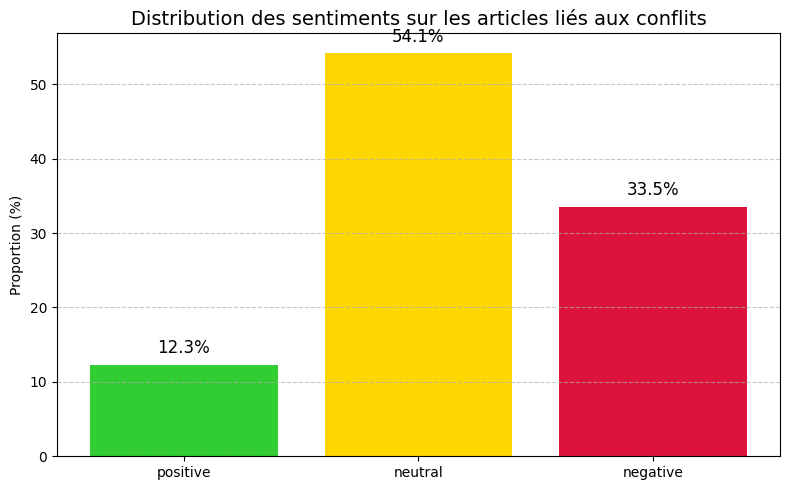

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier avec les sentiments
df = pd.read_csv(PATH+'Output/paired_countries_with_sentiment.csv')

# Calcul des proportions
sentiment_dist = df['sentiment_label'].value_counts(normalize=True) * 100
sentiment_dist = sentiment_dist.round(2)

# Plot
plt.figure(figsize=(8, 5))
colors = ['#32CD32', '#FFD700', '#DC143C']  # vert, or, rouge pour positive, neutral, negative
sentiment_order = ['positive', 'neutral', 'negative']  # pour contrôler l’ordre

bars = plt.bar(sentiment_order, sentiment_dist[sentiment_order], color=colors)

# Annotations sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

# Style du plot
plt.title('Distribution des sentiments sur les articles liés aux conflits', fontsize=14)
plt.ylabel('Proportion (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

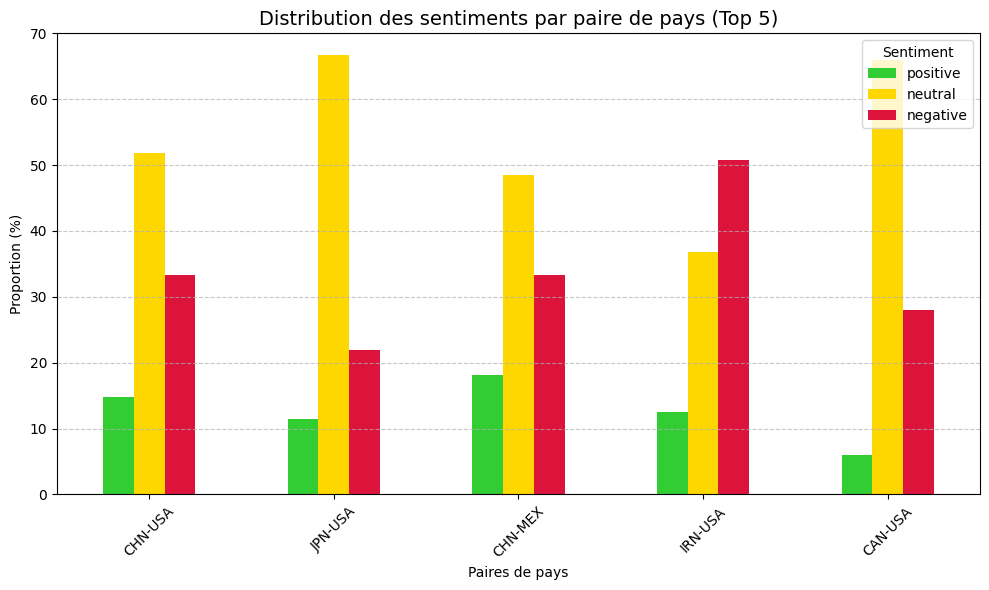

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(PATH+'Output/paired_countries_with_sentiment.csv')

# Top 5 country pairs (can also be automated)
top_pairs = ['CHN-USA', 'JPN-USA', 'CHN-MEX', 'IRN-USA', 'CAN-USA']
sentiments = ['positive', 'neutral', 'negative']
colors = ['#32CD32', '#FFD700', '#DC143C']

# Prepare data
pair_sentiment_data = {}

for pair in top_pairs:
    subset = df[df['country_pair'] == pair]
    sentiment_counts = subset['sentiment_label'].value_counts(normalize=True) * 100
    sentiment_counts = sentiment_counts.reindex(sentiments).fillna(0)
    pair_sentiment_data[pair] = sentiment_counts

# Convert to DataFrame
plot_df = pd.DataFrame(pair_sentiment_data).T  # .T to have pairs as rows
plot_df = plot_df[sentiments]  # ensure column order

# Plot grouped bar chart
plot_df.plot(kind='bar', figsize=(10, 6), color=colors)

plt.title("Distribution des sentiments par paire de pays (Top 5)", fontsize=14)
plt.ylabel("Proportion (%)")
plt.xlabel("Paires de pays")
plt.legend(title="Sentiment", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


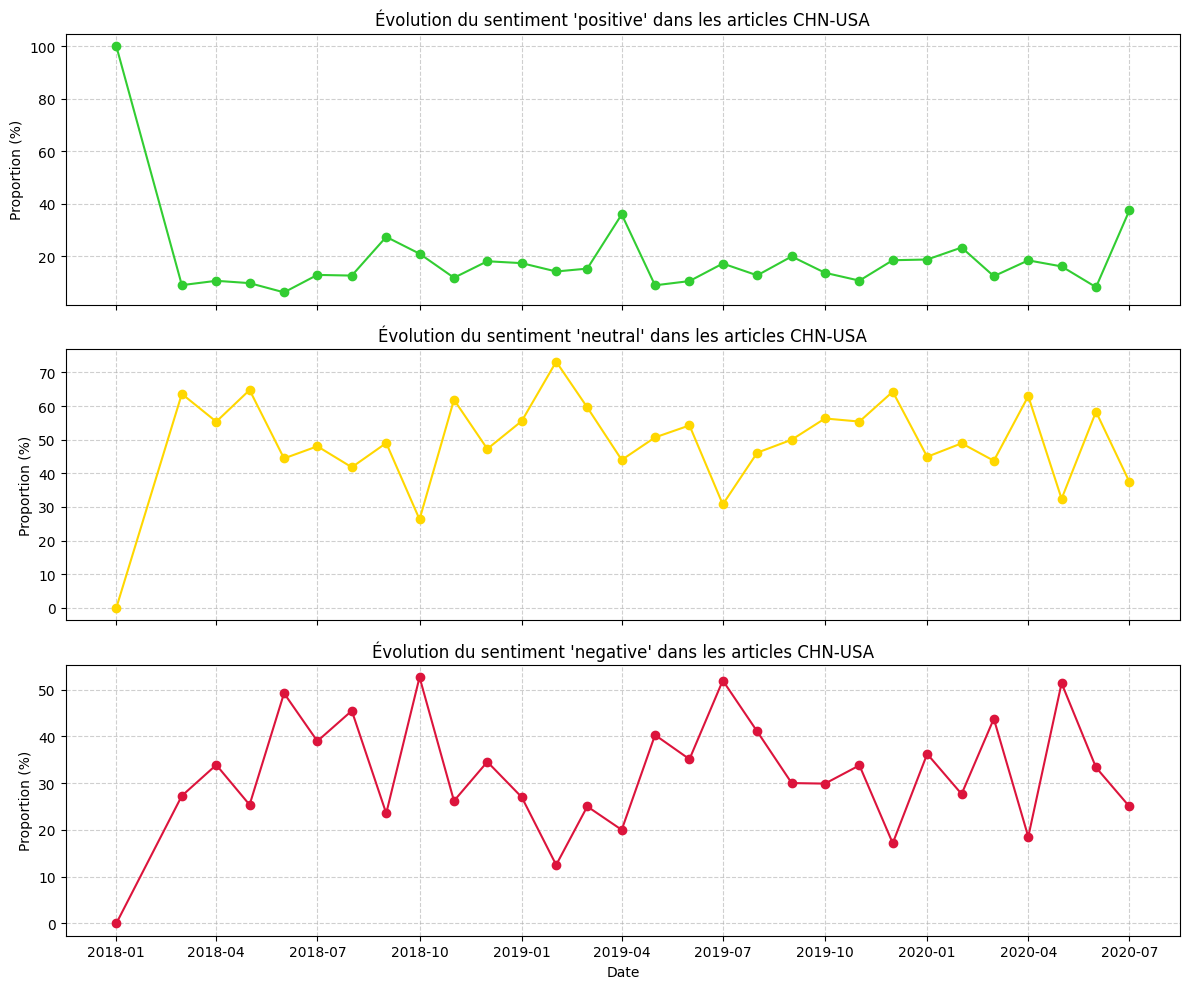

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv(PATH+'Output/paired_countries_with_sentiment.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 1. Filtrer les articles CHN-USA
df_chn_usa = df[df['country_pair'] == 'CHN-USA'].copy()

# 2. Créer une colonne 'month'
df_chn_usa['month'] = df_chn_usa['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compter les sentiments par mois
counts = df_chn_usa.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)

# 4. Calculer les proportions (%)
proportions = counts.div(counts.sum(axis=1), axis=0) * 100
proportions = proportions[['positive', 'neutral', 'negative']]  # pour garder l'ordre

# 5. Tracer les courbes séparées
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

colors = {
    'positive': '#32CD32',
    'neutral': '#FFD700',
    'negative': '#DC143C'
}

for i, sentiment in enumerate(proportions.columns):
    axs[i].plot(proportions.index, proportions[sentiment], marker='o', color=colors[sentiment])
    axs[i].set_title(f"Évolution du sentiment '{sentiment}' dans les articles CHN-USA")
    axs[i].set_ylabel("Proportion (%)")
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[2].set_xlabel("Date")
plt.tight_layout()
plt.show()


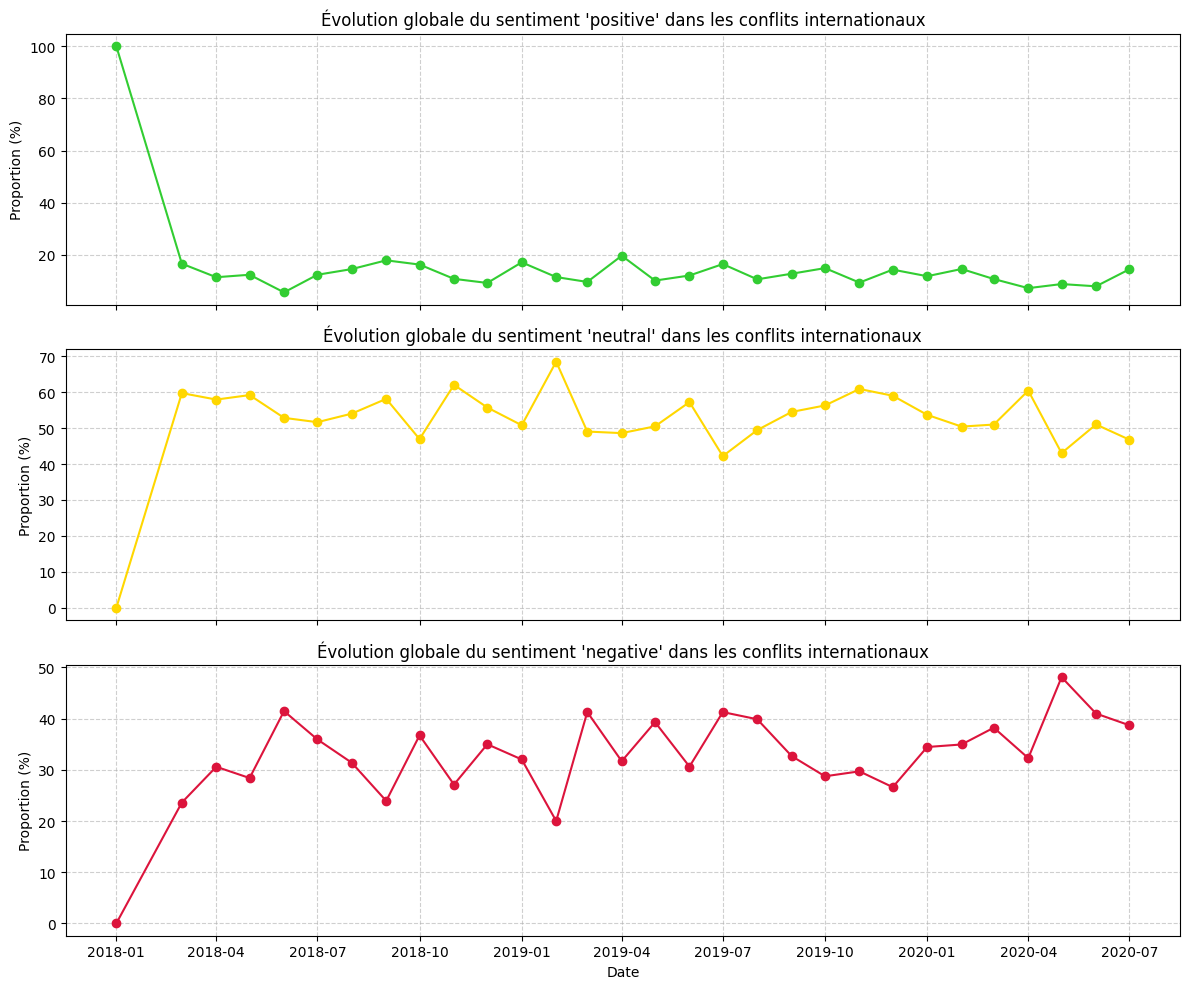

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv(PATH+'Output/paired_countries_with_sentiment.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ajouter la colonne 'month'
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Compter les sentiments par mois (toutes paires confondues)
counts = df.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)

# Calculer les proportions (%)
proportions = counts.div(counts.sum(axis=1), axis=0) * 100
proportions = proportions[['positive', 'neutral', 'negative']]  # garder l'ordre

# Tracer l’évolution globale
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

colors = {
    'positive': '#32CD32',
    'neutral': '#FFD700',
    'negative': '#DC143C'
}

for i, sentiment in enumerate(proportions.columns):
    axs[i].plot(proportions.index, proportions[sentiment], marker='o', color=colors[sentiment])
    axs[i].set_title(f"Évolution globale du sentiment '{sentiment}' dans les conflits internationaux")
    axs[i].set_ylabel("Proportion (%)")
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[2].set_xlabel("Date")
plt.tight_layout()
plt.show()


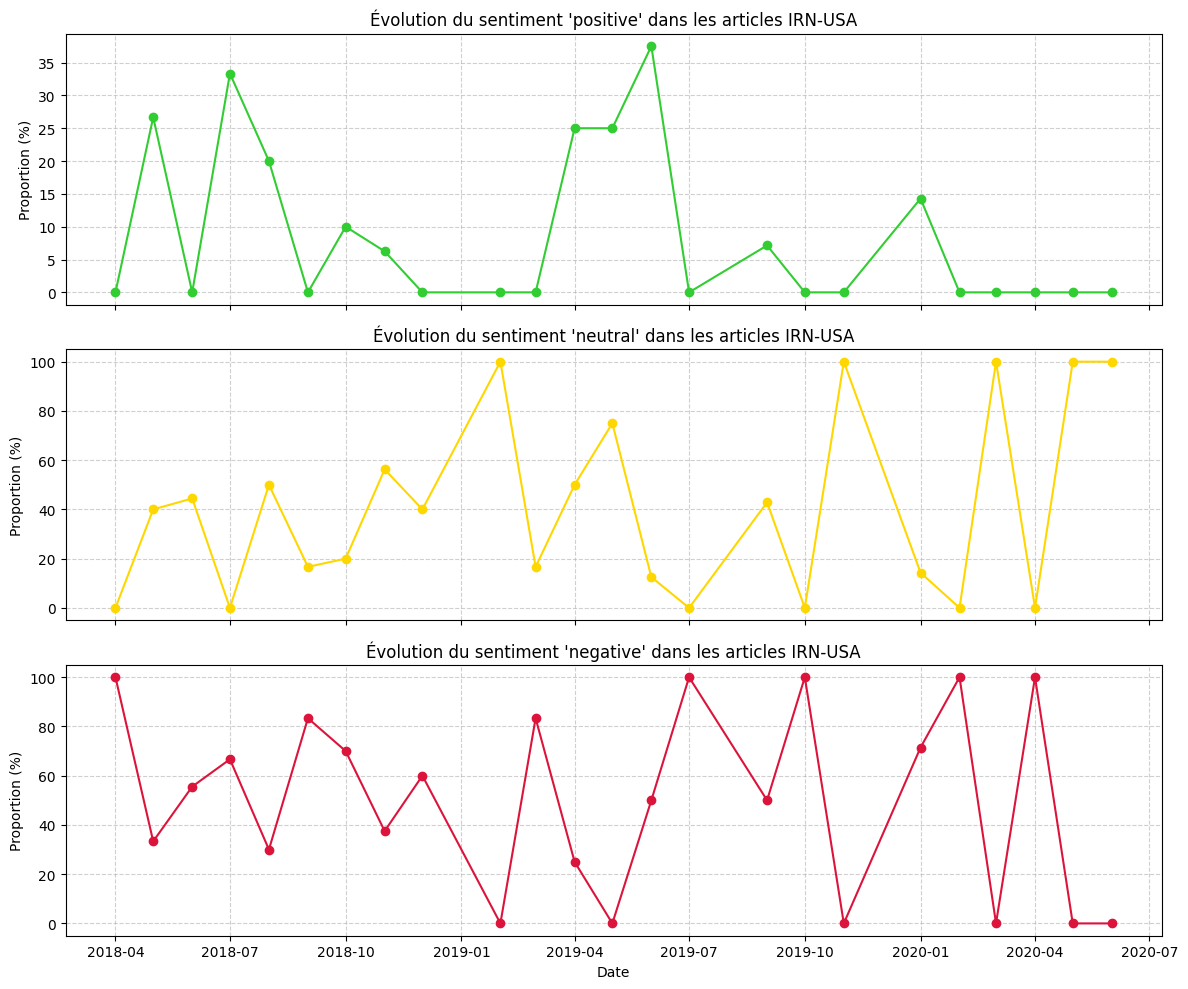

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv(PATH+'Output/paired_countries_with_sentiment.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 1. Filtrer la paire IRN-USA
df_iran_usa = df[df['country_pair'] == 'IRN-USA'].copy()

# 2. Créer une colonne 'month'
df_iran_usa['month'] = df_iran_usa['date'].dt.to_period('M').dt.to_timestamp()

# 3. Compter les sentiments par mois
counts = df_iran_usa.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)

# 4. Calculer les proportions (%)
proportions = counts.div(counts.sum(axis=1), axis=0) * 100
proportions = proportions[['positive', 'neutral', 'negative']]  # pour garder l'ordre

# 5. Tracer les 3 courbes
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

colors = {
    'positive': '#32CD32',
    'neutral': '#FFD700',
    'negative': '#DC143C'
}

for i, sentiment in enumerate(proportions.columns):
    axs[i].plot(proportions.index, proportions[sentiment], marker='o', color=colors[sentiment])
    axs[i].set_title(f"Évolution du sentiment '{sentiment}' dans les articles IRN-USA")
    axs[i].set_ylabel("Proportion (%)")
    axs[i].grid(True, linestyle='--', alpha=0.6)

axs[2].set_xlabel("Date")
plt.tight_layout()
plt.show()
